<a href="https://colab.research.google.com/github/mykolesiko/eeg_article/blob/main/MADE_SamEn_IDF_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math

In [ ]:
pip install pyhht

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install antropy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 2.6 MB/s 
  Created wheel for antropy: filename=antropy-0.1.4-py3-none-any.whl size=16159 sha256=a771bf3b0e5ae04ac84026ebd0959b7e632e6bcfcbed78e98e1f51c1abe5ab0c
  Stored in directory: /root/.cache/pip/wheels/d4/cc/6b/28fa7036bdabc6f1f92fd6a108ae259dbb48f107f676d6b491
Successfully built antropy


In [ ]:
# def dist(x, y, m):
#   return (max(abs(x - y)))


# def get_x(u, m, r):
#   N = len(u)
#   x = np.zeros((N - m + 1, m)) 
#   for i in range(N - m + 1):
#     for j in range(m):
#       x[i][j] = u[i + j]
#   return x

# def C_i_m(i, m, r, N, x):      
#   temp = [1 for j in range(N - m) if ((dist(x[i], x[j], m) < r) and (i != j))]
#   return np.sum(temp)/(N - m - 1)


# def B_m_r(x, N , m, r):
#   result = 0
#   for i in range(N - m):
#     result += C_i_m(i, m, r, N, x)
#   result = result/(N - m)  
#   return result  

# def B_mnext_r(x, N , m, r):
#   result = 0
#   for i in range(1, N - m):
#     result += C_i_m(i, m + 1, r, N, x)
#   result = result/(N - m)  
#   return result  

# def SampEn(u, m, r):
#   N = len(u)
#   x = get_x(u, m, r)
#   B = B_m_r(x, N, m, r)
#   print(B)
#   Bnext = B_mnext_r(x, N, m, r)
#   print(Bnext)
#   result = -math.log(Bnext/B)


# import numpy as np

# def SampEn(L, m, r):
#     N = len(L)
#     B = 0.0
#     A = 0.0
    
    
#     # Split time series and save all templates of length m
#     xmi = np.array([L[i : i + m] for i in range(N - m)])
#     xmj = np.array([L[i : i + m] for i in range(N - m + 1)])

#     # Save all matches minus the self-match, compute B
#     B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])

#     # Similar for computing A
#     m += 1
#     xm = np.array([L[i : i + m] for i in range(N - m + 1)])

#     A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])

#     # Return SampEn
#     result = -np.log(A / B)
#     if np.isinf(result):
#       print(result)

#     if np.isnan(result):
#         print(result)


#     return result



from sklearn.neighbors import KDTree

def _embed(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array
        Time series, of shape (n_times)
    order : int
        Embedding dimension (order).
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray
        Embedded time-series, of shape (n_times - (order - 1) * delay, order)
    """
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[(i * delay):(i * delay + Y.shape[1])]
    return Y.T

def sample_entropy(x, order, r, metric='chebyshev', approximate=False):
    """Utility function for `app_entropy`` and `sample_entropy`.
    """
    _all_metrics = KDTree.valid_metrics
    if metric not in _all_metrics:
        raise ValueError('The given metric (%s) is not valid. The valid '
                         'metric names are: %s' % (metric, _all_metrics))
    phi = np.zeros(2)
    r *= np.std(x, ddof=0)

    # compute phi(order, r)
    _emb_data1 = _embed(x, order, 1)
    if approximate:
        emb_data1 = _emb_data1
    else:
        emb_data1 = _emb_data1[:-1]
    count1 = KDTree(emb_data1, metric=metric).query_radius(emb_data1, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    # compute phi(order + 1, r)
    emb_data2 = _embed(x, order + 1, 1)
    count2 = KDTree(emb_data2, metric=metric).query_radius(emb_data2, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    if approximate:
        phi[0] = np.mean(np.log(count1 / emb_data1.shape[0]))
        phi[1] = np.mean(np.log(count2 / emb_data2.shape[0]))
    else:
        phi[0] = np.mean((count1 - 1) / (emb_data1.shape[0] - 1))
        phi[1] = np.mean((count2 - 1) / (emb_data2.shape[0] - 1))
    #return phi
    return -np.log(np.divide(phi[1], phi[0]))


# def sample_entropy(x, order, r):
#     """
#     Fast evaluation of the sample entropy using Numba.
#     """
#     n = x.size
#     n1 = n - 1
#     order += 1
#     order_dbld = 2 * order

#     # Define threshold
#     r *= x.std()

#     # initialize the lists
#     run = [0] * n
#     run1 = run[:]
#     r1 = [0] * (n * order_dbld)
#     a = [0] * order
#     b = a[:]
#     p = a[:]

#     for i in range(n1):
#         nj = n1 - i

#         for jj in range(nj):
#             j = jj + i + 1
#             if abs(x[j] - x[i]) < r:
#                 run[jj] = run1[jj] + 1
#                 m1 = order if order < run[jj] else run[jj]
#                 for m in range(m1):
#                     a[m] += 1
#                     if j < n1:
#                         b[m] += 1
#             else:
#                 run[jj] = 0
#         for j in range(order_dbld):
#             run1[j] = run[j]
#             r1[i + n * j] = run[j]
#         if nj > order_dbld - 1:
#             for j in range(order_dbld, nj):
#                 run1[j] = run[j]

#     m = order - 1

#     while m > 0:
#         b[m] = b[m - 1]
#         m -= 1

#     b[0] = n * n1 / 2
#     a = np.array([float(aa) for aa in a])
#     b = np.array([float(bb) for bb in b])
#     p = np.true_divide(a, b)
#     return -np.log(p[-1])




In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from pyhht.emd import EMD
from pyhht.visualization import plot_imfs

def get_imfs(x):
  
    # Загрузить данные временных рядов
    #data = pd.read_csv('D:/passengervolume.csv',header=None)
    #EMD Эмпирическая модальная декомпозиция
    n = len(x)
    decomposer = EMD(x, n_imfs = 4)               
    imfs = decomposer.decompose()
    #plot_imfs(x,  imfs, np.arange(n))
    return imfs
    


In [ ]:
import os
os.chdir("/content/drive/MyDrive/MADE/Project/deap")

In [ ]:
import glob
import pickle
data = []
labels = []
data_dir = './data_preprocessed_python'
files = glob.glob(os.path.join(data_dir, "*.dat"))

for file_data in files:
    raw_data = pickle.load(open(file_data, 'rb'), encoding='latin1')
    data.append(raw_data['data'])
    labels.append(raw_data['labels'])

In [ ]:
 result = get_imfs(data[0][0, 0, :])

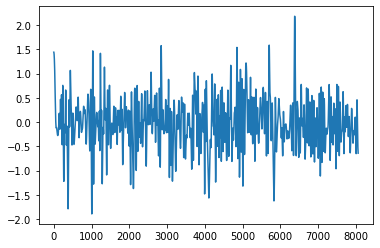

In [ ]:
plt.plot(result[4, :])

In [ ]:
import antropy as ant
m = 3
r = 0.25
interval = 128
#def get_features(m, r, interval):
n = int(1152/interval)
features = np.zeros((32, 40, 4 * 2 * n))
for sub in range(0, 32):
    print(f"sub = {sub}")
    for nvideo in range(40):
        #print(nvideo)
        ifms1 = get_imfs(data[sub][nvideo, 2,  33 * 128 : 42 * 128])
        ifms2 = get_imfs(data[sub][nvideo, 24,  33 * 128 : 42 * 128])
        k = 0
        for i  in range(4):
            for nsec in range(0, 1152, interval):
                temp = ant.sample_entropy(ifms1[i][nsec: nsec + interval], 1)
                #temp = SampEn(ifms1[i][nsec: nsec + interval], m, r)
                #temp = sample_entropy(ifms1[i][nsec: nsec + interval], m, r)
                #print(temp)
                features[sub, nvideo, k] = temp
                k += 1
                temp = ant.sample_entropy(ifms2[i][nsec: nsec + interval], 1)
                #temp = sample_entropy(ifms2[i][nsec: nsec + interval], m, r)
                #temp = SampEn(ifms2[i][nsec: nsec + interval], m, r)
                #print(temp)
                features[sub, nvideo, k] = temp
                k += 1
   #return features             


sub = 0
sub = 1
sub = 2
sub = 3
sub = 4
sub = 5
sub = 6
sub = 7
sub = 8
sub = 9
sub = 10
sub = 11
Mode 4, Iteration 600
0 minima > 0; 40 maxima < 0.
sub = 12
sub = 13
sub = 14
sub = 15
sub = 16
sub = 17
sub = 18
sub = 19
sub = 20
sub = 21
sub = 22
sub = 23
sub = 24
sub = 25
sub = 26
sub = 27
sub = 28
sub = 29
sub = 30
sub = 31


In [ ]:
print(features)

In [ ]:
#features = get_features(1, 0.15, 128)

In [ ]:
print(features.shape)

(32, 40, 72)


In [ ]:
print(features[1][0])

[3.87639583 3.66612247 0.         0.         0.         3.49144426
 0.         4.29045944 0.         4.14048572 3.59273559 3.2054528
 3.59043938 3.53368656 3.25809654 4.54859983 0.         3.55248683
 0.         2.71359038 3.4657359  3.61765194 3.54817957 3.78418963
 4.34380542 3.95842938 0.         3.75731662 0.         3.263576
 4.31748811 3.03735395 0.         3.04111528 3.61988658 3.06514172
 0.         2.42774824 0.         2.37822251 0.         1.90251083
 2.60268969 2.88417979 0.         4.13516656 0.         2.83321334
 3.44998755 2.73336801 2.49869997 1.89519506 2.96183072 2.81264119
 2.03552231 0.74524229 0.82472354 0.87071322 2.19722458 0.82728874
 2.41591378 1.35533214 1.40876722 1.31836025 1.91416145 1.23604232
 1.64470605 1.15492346 1.4045098  0.78671974 1.58240924 0.35963666]


In [ ]:
# import pickle
# with open("ifms_features_0.05_2", "wb") as fp:
#   pickle.dump(features, fp)

In [ ]:
# import pickle
# with open("ifms_features_good", "rb") as fp:
#    features = pickle.load(fp)

In [ ]:
HAHV = 0
LAHV = 1
LALV = 2
HALV = 3
labels_bin = np.zeros((32, 40, 1))
labels = np.array(labels)
#for i in range(32):
HV = labels[:, :, 0:1] >= 5
HA = labels[:, :, 1:2] >= 5
LV = labels[:, :, 0:1] < 5
LA = labels[:, :, 1:2] < 5
labels_bin[HA & HV] = HAHV
labels_bin[LA & HV] = LAHV
labels_bin[LA & LV] = LALV
labels_bin[HA & LV] = HALV


#labels_all_bin = np.vstack(labels_bin)  

In [ ]:
X = features.reshape(-1, 72)
y = labels_bin.reshape(-1, 1).ravel()

In [ ]:
#pip install -U libsvm-official
#from libsvm.svmutil import *

In [ ]:
# X = features.reshape(-1, 72)
# y = labels_bin.reshape(-1, 1).ravel()


In [ ]:
from sklearn.preprocessing import StandardScaler

X_scales = StandardScaler().fit_transform(X)

In [ ]:
print(pow)

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV


pows2 = [2.0 ** n for n in np.arange(-10, 10, 1)]
parameters = {'kernel':(['rbf']), 'C': pows2, 'gamma' : pows2, 'class_weight': (['balanced'])}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy', cv=5, n_jobs=-1)
clf.fit(X, y)






#from sklearn.svm import SVC
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#clf.fit(X, y)
##Pipeline(steps=[('standardscaler', StandardScaler()),
  #              ('svc', SVC(gamma='auto'))])

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0009765625, 0.001953125, 0.00390625, 0.0078125,
                               0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0,
                               2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0,
                               512.0],
                         'class_weight': ['balanced'],
                         'gamma': [0.0009765625, 0.001953125, 0.00390625,
                                   0.0078125, 0.015625, 0.03125, 0.0625, 0.125,
                                   0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0,
                                   64.0, 128.0, 256.0, 512.0],
                         'kernel': ['rbf']},
             scoring='accuracy')

In [ ]:
print(clf.best_score_, clf.best_params_)

0.3578125 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 2.0, 'kernel': 'rbf'}


In [ ]:
from sklearn.impute import SimpleImputer
  
# Using Imputer function to replace NaN
# values with mean of that parameter value
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X1 = imputer.fit_transform(X1)

In [ ]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scales, y, test_size=0.1, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    svc = svm.SVC(C=0.0009765625, class_weight = 'balanced', gamma = 2.0, kernel = 'rbf', decision_function_shape ='ovo')
    svc.fit(X_train, y_train)
    pred = svc.predict(X_test)
    print(accuracy_score(pred, y_test))




0.2578125
0.2109375
0.359375
0.21875
0.234375
0.234375
0.1953125
0.4140625
0.3671875
0.234375
0.2578125
0.359375
0.3203125
0.2109375
0.171875
0.1640625
0.3125
0.296875
0.2578125
0.21875
0.1875
0.234375
0.265625
0.1875


KeyboardInterrupt: ignored

In [ ]:
from sklearn import svm, datasets
#from sklearn.ensemble import RandomForestClassifier
svc = svm.SVC(C=0.0009765625, class_weight = 'balanced', gamma = 2.0, kernel = 'rbf')
#model = RandomForestClassifier(500)
svc.fit(X_train, y_train)
#model.fit(X_train, y_train)

SVC(C=0.0009765625, class_weight='balanced', gamma=2.0)

In [ ]:
from sklearn.metrics import accuracy_score

pred = svc.predict(X_test)
#pred = model.predict(X_test)
print(accuracy_score(pred, y_test))

0.2
